# **BirdCLEF 2025 Training Notebook**

This is a baseline training pipeline for BirdCLEF 2025 using EfficientNetB0 with PyTorch and Timm(for pretrained EffNet). You can check inference and preprocessing notebooks in the following links: 

- [EfficientNet B0 Pytorch [Inference] | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/efficientnet-b0-pytorch-inference-birdclef-25)

  
- [Transforming Audio-to-Mel Spec. | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/transforming-audio-to-mel-spec-birdclef-25)  

Note that by default this notebook is in Debug Mode, so it will only train the model with 2 epochs, but the [weight](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-effnetb0-starter-weight) I used in the inference notebook was obtained after 10 epochs of training.

**Features**
* Implement with Pytorch and Timm
* Flexible audio processing with both pre-computed and on-the-fly mel spectrograms
* Stratified 5-fold cross-validation with ensemble capability
* Mixup training for improved generalization
* Spectrogram augmentations (time/frequency masking, brightness adjustment)
* AdamW optimizer with Cosine Annealing LR scheduling
* Debug mode for quick experimentation with smaller datasets

**Pre-computed Spectrograms**
For faster training, you can use pre-computed mel spectrograms from [this dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) by setting `LOAD_DATA = True`

## Libraries

In [1]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (roc_curve, auc, f1_score, precision_score, 
                                  recall_score, average_precision_score, 
                                  precision_recall_curve)
import librosa

import torch
import torch.nn as nn
from torch.cuda.amp import autocast,GradScaler
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import glob
import time
import timm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

## Configuration

In [2]:
class CFG:
    
    seed = 42
    debug = False  
    num_workers = 4
    persistent_workers = True
    
    OUTPUT_DIR = '/kaggle/working/'
    train_unlabeled = '/kaggle/input/birdclef-2025/train_soundscapes'
    train_datadir = '/kaggle/input/birdclef-2025/train_audio'
    train_csv = '/kaggle/input/birdclef-2025/train.csv'
    test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
    submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
    taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
    teacher_weights = '/kaggle/input/birdclef25-effnetb0-starter-weight/best.pth'

    spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'

    pseudo_threshold = 0.95
    pseudo_label_usage = True
    
    model_name = 'efficientnet_b0'  
    pretrained = True
    in_channels = 1

    LOAD_DATA = True  
    FS = 32000
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)
    
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epochs = 10  
    epochs_student = 10
    batch_size = 32  
    criterion = 'BCEWithLogitsLoss'

    n_fold = 5
    selected_folds = [0]   

    optimizer = 'AdamW'
    lr = 5e-4 
    weight_decay = 1e-5
  
    scheduler = 'CosineAnnealingLR'
    min_lr = 1e-6
    T_max = epochs

    aug_prob = 0.3 
    mixup_alpha = 0.3  
    batch_size_student = 48
    pseudo_loss_weight = 0.5
    
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 8
            self.selected_folds = [0]

cfg = CFG()

## Utilities

In [3]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

## Pre-processing
These functions handle the transformation of audio files to mel spectrograms for model input, with flexibility controlled by the `LOAD_DATA` parameter. The process involves either loading pre-computed spectrograms from this [dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) (when `LOAD_DATA=True`) or dynamically generating them (when `LOAD_DATA=False`), transforming audio data into spectrogram representations, and preparing it for the neural network.

In [4]:
def audio2melspec(audio_data, cfg):
    """Convert audio data to mel spectrogram"""
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=cfg.FS,
        n_fft=cfg.N_FFT,
        hop_length=cfg.HOP_LENGTH,
        n_mels=cfg.N_MELS,
        fmin=cfg.FMIN,
        fmax=cfg.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

def process_audio_file(audio_path, cfg):
    """Process a single audio file to get the mel spectrogram"""
    try:
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)

        target_samples = int(cfg.TARGET_DURATION * cfg.FS)

        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        # Extract center 5 seconds
        start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='constant')

        mel_spec = audio2melspec(center_audio, cfg)
        
        if mel_spec.shape != cfg.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        return mel_spec.astype(np.float32)
        
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def generate_spectrograms(df, cfg):
    """Generate spectrograms from audio files"""
    print("Generating mel spectrograms from audio files...")
    start_time = time.time()

    all_bird_data = {}
    errors = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        if cfg.debug and i >= 1000:
            break
        
        try:
            samplename = row['samplename']
            filepath = row['filepath']
            
            mel_spec = process_audio_file(filepath, cfg)
            
            if mel_spec is not None:
                all_bird_data[samplename] = mel_spec
            
        except Exception as e:
            print(f"Error processing {row.filepath}: {e}")
            errors.append((row.filepath, str(e)))

    end_time = time.time()
    print(f"Processing completed in {end_time - start_time:.2f} seconds")
    print(f"Successfully processed {len(all_bird_data)} files out of {len(df)}")
    print(f"Failed to process {len(errors)} files")
    
    return all_bird_data

## Dataset Preparation and Data Augmentations
We'll convert audio to mel spectrograms and apply random augmentations with 50% probability each - including time stretching, pitch shifting, and volume adjustments. This randomized approach creates diverse training samples from the same audio files

In [5]:
class BirdCLEFDatasetFromNPY(Dataset):
    def __init__(self, df, cfg, spectrograms=None, mode="train"):
        self.df = df
        self.cfg = cfg
        self.mode = mode
        self.spectrograms = spectrograms
        
        taxonomy_df = pd.read_csv(self.cfg.taxonomy_csv)
        self.species_ids = taxonomy_df['primary_label'].tolist()
        self.num_classes = len(self.species_ids)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.species_ids)}

        if 'filepath' not in self.df.columns:
            self.df['filepath'] = self.cfg.train_datadir + '/' + self.df.filename
        
        if 'samplename' not in self.df.columns:
            self.df['samplename'] = self.df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

        sample_names = set(self.df['samplename'])
        if self.spectrograms:
            found_samples = sum(1 for name in sample_names if name in self.spectrograms)
            print(f"Found {found_samples} matching spectrograms for {mode} dataset out of {len(self.df)} samples")
        
        if cfg.debug:
            self.df = self.df.sample(min(1000, len(self.df)), random_state=cfg.seed).reset_index(drop=True)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        samplename = row['samplename']
        spec = None
        
        # ========================================================
        # 1. SPECTOGRAM LOAD
        # ========================================================
        
        if self.spectrograms and samplename in self.spectrograms:
            spec = self.spectrograms[samplename]
        
        elif row.get('is_pseudo', False):
            try:
                audio, _ = librosa.load(
                    row['filepath'], 
                    sr=self.cfg.FS, 
                    offset=row['start_time'], 
                    duration=self.cfg.TARGET_DURATION
                )
                
                target_len = int(self.cfg.TARGET_DURATION * self.cfg.FS)
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
                
                spec = audio2melspec(audio, self.cfg)
                
                if spec.shape != self.cfg.TARGET_SHAPE:
                    spec = cv2.resize(spec, self.cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
                    
            except Exception as e:
                print(f"Error loading pseudo audio {samplename}: {e}")
                spec = np.zeros(self.cfg.TARGET_SHAPE, dtype=np.float32)
    
        elif not self.cfg.LOAD_DATA:
            spec = process_audio_file(row['filepath'], self.cfg)
    
        if spec is None:
            spec = np.zeros(self.cfg.TARGET_SHAPE, dtype=np.float32)
            if self.mode == "train" and not row.get('is_pseudo', False):
                print(f"Warning: Spectrogram for {samplename} not found")
    
        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)
    
        # ========================================================
        # 2. AUGMENTATIONS
        # ========================================================
        if self.mode == "train" and random.random() < self.cfg.aug_prob:
            spec = self.apply_spec_augmentations(spec)
        
        # ========================================================
        # 3. TARGETS
        # ========================================================
        has_vector = False
        if 'target_vector' in row:
            val = row['target_vector']
            if isinstance(val, (np.ndarray, list)) and len(val) > 1:
                has_vector = True
            elif isinstance(val, str): 
                has_vector = True
    
        if has_vector:
            target = row['target_vector']
            if isinstance(target, str):
                target = np.array(eval(target), dtype=np.float32)
            else:
                target = np.array(target, dtype=np.float32)
        else:
            target = self.encode_label(row['primary_label'])
            if 'secondary_labels' in row and row['secondary_labels'] not in [[''], None, np.nan]:
                if isinstance(row['secondary_labels'], str):
                    seclabels = eval(row['secondary_labels'])
                else:
                    seclabels = row['secondary_labels']
                for label in seclabels:
                    if label in self.label_to_idx:
                        target[self.label_to_idx[label]] = 1.0
    
        return {
            'melspec': spec, 
            'target': torch.tensor(target, dtype=torch.float32),
            'filename': row['filename']
        }
    
    def apply_spec_augmentations(self, spec):
        """Apply augmentations to spectrogram"""
    
        if random.random() < 0.5:
            num_masks = random.randint(1, 3)
            for _ in range(num_masks):
                width = random.randint(5, 20)
                start = random.randint(0, spec.shape[2] - width)
                spec[0, :, start:start+width] = 0
        
        if random.random() < 0.5:
            num_masks = random.randint(1, 3)
            for _ in range(num_masks):
                height = random.randint(5, 20)
                start = random.randint(0, spec.shape[1] - height)
                spec[0, start:start+height, :] = 0
        
        if random.random() < 0.5:
            gain = random.uniform(0.8, 1.2)
            bias = random.uniform(-0.1, 0.1)
            spec = spec * gain + bias
            spec = torch.clamp(spec, 0, 1) 
            
        return spec
    
    def encode_label(self, label):
        """Encode label to one-hot vector"""
        target = np.zeros(self.num_classes)
        if label in self.label_to_idx:
            target[self.label_to_idx[label]] = 1.0
        return target

In [6]:
class UnlabeledWindowDataset(Dataset):
    def __init__(self, audio_paths, cfg):
        self.audio_paths = audio_paths
        self.cfg = cfg
        self.samples = []
        
        for path in tqdm(audio_paths):
            try:
                duration = librosa.get_duration(filename=path)
                num_windows = int(duration // cfg.TARGET_DURATION)
                
                for i in range(num_windows):
                    self.samples.append({
                        'filepath': path,
                        'start_time': i * cfg.TARGET_DURATION
                    })
            except Exception as e:
                print(f"Error indexando {path}: {e}")
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        path = sample['filepath']
        offset = sample['start_time']
        
        audio, _ = librosa.load(path, sr=self.cfg.FS, offset=offset, duration=self.cfg.TARGET_DURATION)
        
        target_len = int(self.cfg.TARGET_DURATION * self.cfg.FS)
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
            
        mel_spec = audio2melspec(audio, self.cfg)
        
        if mel_spec.shape != self.cfg.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, self.cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
            
        spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)
        
        return {
            'melspec': spec,
            'filepath': path,
            'start_time': offset
        }

In [7]:
def generate_pseudo_labels(model, unlabeled_paths, cfg, device):
    model.eval()
    dataset = UnlabeledWindowDataset(unlabeled_paths, cfg)
    loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False, 
                       num_workers=4, pin_memory=True)
    
    pseudo_data = []
    pseudo_spectrograms = {}
    
    print(f"Generating Pseudo-Labels (Threshold: {cfg.pseudo_threshold})...")
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            inputs = batch['melspec'].to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            filepaths = batch['filepath']
            start_times = batch['start_time'].numpy()
            melspecs = batch['melspec'].cpu().numpy()
            
            for j in range(len(probs)):
                pred_prob = probs[j]
                if np.max(pred_prob) > cfg.pseudo_threshold:
                    samplename = f"pseudo_{os.path.basename(filepaths[j])}_{start_times[j]:.1f}"
                    
                    entry = {
                        'filepath': filepaths[j],
                        'start_time': start_times[j],
                        'samplename': samplename,
                        'primary_label': 'pseudo',
                        'filename': f"pseudo/{samplename}.ogg",
                        'target_vector': pred_prob,
                        'is_pseudo': True
                    }
                    pseudo_data.append(entry)
                    
                    pseudo_spectrograms[samplename] = melspecs[j, 0]  # Shape (256, 256)
    
    print(f"Found {len(pseudo_data)} pseudo-labels.")
    print(f"Pseudo spectrograms size: ~{len(pseudo_spectrograms) * 256 * 256 * 4 / 1e6:.1f} MB")
    
    return pd.DataFrame(pseudo_data), pseudo_spectrograms

In [8]:
def collate_fn(batch):
    """Custom collate function to handle different sized spectrograms"""
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return {}
        
    result = {key: [] for key in batch[0].keys()}
    
    for item in batch:
        for key, value in item.items():
            result[key].append(value)
    
    for key in result:
        if key == 'target' and isinstance(result[key][0], torch.Tensor):
            result[key] = torch.stack(result[key])
        elif key == 'melspec' and isinstance(result[key][0], torch.Tensor):
            shapes = [t.shape for t in result[key]]
            if len(set(str(s) for s in shapes)) == 1:
                result[key] = torch.stack(result[key])
    
    return result

## Model Definition

In [9]:
class BirdCLEFModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        cfg.num_classes = len(taxonomy_df)
        
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=cfg.pretrained,
            in_chans=cfg.in_channels,
            drop_rate=0.2,
            drop_path_rate=0.2
        )
        
        if 'efficientnet' in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'resnet' in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            backbone_out = self.backbone.get_classifier().in_features
            self.backbone.reset_classifier(0, '')
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
            
        self.feat_dim = backbone_out
        
        self.classifier = nn.Linear(backbone_out, cfg.num_classes)
        
        self.mixup_enabled = hasattr(cfg, 'mixup_alpha') and cfg.mixup_alpha > 0
        if self.mixup_enabled:
            self.mixup_alpha = cfg.mixup_alpha
            
    def forward(self, x, targets=None):
    
        if self.training and self.mixup_enabled and targets is not None:
            mixed_x, targets_a, targets_b, lam = self.mixup_data(x, targets)
            x = mixed_x
        else:
            targets_a, targets_b, lam = None, None, None
        
        features = self.backbone(x)
        
        if isinstance(features, dict):
            features = features['features']
            
        if len(features.shape) == 4:
            features = self.pooling(features)
            features = features.view(features.size(0), -1)
        
        logits = self.classifier(features)
        
        if self.training and self.mixup_enabled and targets is not None:
            loss = self.mixup_criterion(F.binary_cross_entropy_with_logits, 
                                       logits, targets_a, targets_b, lam)
            return logits, loss
            
        return logits
    
    def mixup_data(self, x, targets):
        """Applies mixup to the data batch"""
        batch_size = x.size(0)

        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)

        indices = torch.randperm(batch_size).to(x.device)

        mixed_x = lam * x + (1 - lam) * x[indices]
        
        return mixed_x, targets, targets[indices], lam
    
    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        """Applies mixup to the loss function"""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Training Utilities
We are configuring our optimization strategy with the AdamW optimizer, cosine scheduling, and the BCEWithLogitsLoss criterion.

In [10]:
def get_optimizer(model, cfg):
  
    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=cfg.lr,
            weight_decay=cfg.weight_decay
        )
    elif cfg.optimizer == 'AdamW':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=cfg.lr,
            weight_decay=cfg.weight_decay
        )
    elif cfg.optimizer == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=cfg.lr,
            momentum=0.9,
            weight_decay=cfg.weight_decay
        )
    else:
        raise NotImplementedError(f"Optimizer {cfg.optimizer} not implemented")
        
    return optimizer

def get_scheduler(optimizer, cfg):
   
    if cfg.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=cfg.T_max,
            eta_min=cfg.min_lr
        )
    elif cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=cfg.min_lr,
            verbose=True
        )
    elif cfg.scheduler == 'StepLR':
        scheduler = lr_scheduler.StepLR(
            optimizer,
            step_size=cfg.epochs // 3,
            gamma=0.5
        )
    elif cfg.scheduler == 'OneCycleLR':
        scheduler = None  
    else:
        scheduler = None
        
    return scheduler

def get_criterion(cfg):
 
    if cfg.criterion == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()
    else:
        raise NotImplementedError(f"Criterion {cfg.criterion} not implemented")
        
    return criterion

## Training Loop

In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    
    model.train()
    losses = []
    all_targets = []
    all_outputs = []

    scaler = GradScaler()
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
    
    for step, batch in pbar:
    
        if isinstance(batch['melspec'], list):
            batch_outputs = []
            batch_losses = []
            
            for i in range(len(batch['melspec'])):
                inputs = batch['melspec'][i].unsqueeze(0).to(device)
                target = batch['target'][i].unsqueeze(0).to(device)
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                
                batch_outputs.append(output.detach().cpu())
                batch_losses.append(loss.item())
            
            optimizer.step()
            outputs = torch.cat(batch_outputs, dim=0).numpy()
            loss = np.mean(batch_losses)
            targets = batch['target'].numpy()
            
        else:
            inputs = batch['melspec'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if isinstance(outputs, tuple):
                outputs, loss = outputs  
            else:
                loss = criterion(outputs, targets)
                
            loss.backward()
            optimizer.step()
            
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
        
        if scheduler is not None and isinstance(scheduler, lr_scheduler.OneCycleLR):
            scheduler.step()
            
        all_outputs.append(outputs)
        all_targets.append(targets)
        losses.append(loss if isinstance(loss, float) else loss.item())
        
        pbar.set_postfix({
            'train_loss': np.mean(losses[-10:]) if losses else 0,
            'lr': optimizer.param_groups[0]['lr']
        })
    
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    auc = calculate_auc(all_targets, all_outputs)
    avg_loss = np.mean(losses)
    
    return avg_loss, auc

def validate(model, loader, criterion, device):
    model.eval()
    losses = []
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            inputs = batch['melspec'].to(device)
            targets = batch['target'].to(device)
            

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            all_outputs.append(outputs)
            all_targets.append(targets)
            losses.append(loss.item())
    
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    auc = calculate_auc(all_targets, all_outputs)
    avg_loss = np.mean(losses)
    
    return avg_loss, auc

def calculate_auc(targets, outputs):
  
    probs = torch.sigmoid(torch.tensor(outputs)).numpy()
    aucs = []
    num_classes = targets.shape[1]
    
    for i in range(num_classes):
        y_true = targets[:, i]
        y_pred = probs[:, i]
        
        if y_true.dtype == 'float32' or y_true.dtype == 'float64':
            y_true = (y_true >= 0.5).astype(int)
            
        if y_true.sum() > 0 and y_true.sum() < len(y_true):
            try:
                score = roc_auc_score(y_true, y_pred)
                aucs.append(score)
            except ValueError:
                pass
                
    return np.mean(aucs) if aucs else 0.5

In [12]:
def resume_training_student(df, cfg, fold=0, teacher_path=None):
    """
    Optimized function to train the Student model with pseudo-labels.
    Features spectrogram pre-computation for maximum efficiency.
    """
    print(f"\n{'='*60}")
    print(f"Resuming training for Fold {fold} - Student Phase")
    print(f"{'='*60}\n")
    
    # Si no se pasa una ruta específica, usar la por defecto
    if teacher_path is None:
        teacher_path = f"model_fold{fold}_teacher.pth"

    # ========================================================
    # 1. LOAD SPECTROGRAMS
    # ========================================================
    spectrograms = None
    if cfg.LOAD_DATA:
        print("Loading pre-computed mel spectrograms (Real Data)...")
        try:
            spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
            print(f" Loaded {len(spectrograms)} pre-computed spectrograms for real data")
        except Exception as e:
            print(f" Could not load spectrograms: {e}")
            print("Will generate spectrograms on-the-fly")
            spectrograms = {}
    else:
        spectrograms = {}
    
    # ========================================================
    # 2. DATA PREPARATION
    # ========================================================
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    splits = list(skf.split(df, df['primary_label']))
    train_idx, val_idx = splits[fold]
    
    train_df_teacher = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    
    print(f"Train samples: {len(train_df_teacher)}")
    print(f"Validation samples: {len(val_df)}")
    
    val_dataset = BirdCLEFDatasetFromNPY(val_df, cfg, spectrograms=spectrograms, mode='valid')
    val_loader = DataLoader(
        val_dataset, 
        batch_size=cfg.batch_size, 
        shuffle=False, 
        num_workers=cfg.num_workers, 
        pin_memory=True, 
        persistent_workers=True,
        collate_fn=collate_fn
    )

    # ========================================================
    # 3. LOAD TEACHER MODEL
    # ========================================================
    print(f"\nLoading Teacher weights from: {teacher_path}")
    if not os.path.exists(teacher_path):
        print(f"ERROR:  {teacher_path} don't exist.")
        return

    teacher_model = BirdCLEFModel(cfg).to(cfg.device)
    
    checkpoint = torch.load(teacher_path, map_location=cfg.device)
    
    if 'model_state_dict' in checkpoint:
        teacher_model.load_state_dict(checkpoint['model_state_dict'])
        print(f" Teacher loaded (AUC: {checkpoint.get('val_auc', 'N/A')})")
    else:
        teacher_model.load_state_dict(checkpoint)
        print(f" Teacher loaded")
    
    # ========================================================
    # 4. PSEUDO-LABEL GENERATION WITH PRE-COMPUTED SPECTROGRAMS
    # ========================================================
    print(f"\n{'='*60}")
    print("PHASE 2: Generating Pseudo-Labels")
    print(f"{'='*60}\n")
    
    unlabeled_files = glob.glob(os.path.join(cfg.train_unlabeled, '*.ogg'))
    if cfg.debug: 
        unlabeled_files = unlabeled_files[:50]
    
    print(f"Found {len(unlabeled_files)} unlabeled audio files")
    
    pseudo_df, pseudo_spectrograms = generate_pseudo_labels(
        teacher_model, unlabeled_files, cfg, cfg.device
    )
    
    if not pseudo_df.empty:
        print(f"\n Pseudo-Labels Analysis:")
        print(f"   Total pseudo-labels: {len(pseudo_df)}")
        
        confs = [np.max(row['target_vector']) for _, row in pseudo_df.iterrows()]
        print(f"   Average confidence: {np.mean(confs):.3f}")
        print(f"   Min confidence: {np.min(confs):.3f}")
        print(f"   Max confidence: {np.max(confs):.3f}")
        
        if pseudo_spectrograms:
            mem_mb = len(pseudo_spectrograms) * 256 * 256 * 4 / 1e6
            print(f"   Spectrograms memory: ~{mem_mb:.1f} MB")
        
        pseudo_classes = [np.argmax(row['target_vector']) for _, row in pseudo_df.iterrows()]
        print(f"   Unique classes predicted: {len(set(pseudo_classes))}")
    
    del teacher_model, checkpoint
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"\n Teacher model unloaded, memory freed")

    # ========================================================
    # 5. TRAINING FOR STUDENT MODEL
    # ========================================================
    if not pseudo_df.empty:
        print(f"\n{'='*60}")
        print("PHASE 3: Training Student Model")
        print(f"{'='*60}\n")
        
        combined_df = pd.concat([train_df_teacher, pseudo_df], axis=0).reset_index(drop=True)
        print(f"Combined dataset:")
        print(f"   Real samples: {len(train_df_teacher)}")
        print(f"   Pseudo samples: {len(pseudo_df)}")
        print(f"   Total samples: {len(combined_df)}")
        print(f"   Pseudo ratio: {len(pseudo_df)/len(combined_df)*100:.1f}%\n")
        
        combined_spectrograms = spectrograms.copy() if spectrograms else {}
        
        if pseudo_spectrograms:
            combined_spectrograms.update(pseudo_spectrograms)
            print(f"   Spectrograms combined in memory:")
            print(f"   Real spectrograms: {len(spectrograms) if spectrograms else 0}")
            print(f"   Pseudo spectrograms: {len(pseudo_spectrograms)}")
            print(f"   Total in memory: {len(combined_spectrograms)}\n")
        
        train_dataset_student = BirdCLEFDatasetFromNPY(
            combined_df, 
            cfg, 
            spectrograms=combined_spectrograms,
            mode='train'
        )
        
        train_loader_student = DataLoader(
            train_dataset_student, 
            batch_size=cfg.batch_size_student, 
            shuffle=True, 
            num_workers=cfg.num_workers,
            pin_memory=True, 
            persistent_workers=True,
            collate_fn=collate_fn, 
            drop_last=True
        )
        
        print(f"DataLoader configuration:")
        print(f"   Batch size: {cfg.batch_size_student}")
        print(f"   Num workers: {cfg.num_workers}")
        print(f"   Total batches/epoch: {len(train_loader_student)}\n")
        
        student_model = BirdCLEFModel(cfg).to(cfg.device)
        optimizer_s = get_optimizer(student_model, cfg)
        scheduler_s = get_scheduler(optimizer_s, cfg)
        criterion = get_criterion(cfg)
        
        best_auc_student = 0
        final_model_path = f"model_student{fold}.pth"
        
        print(f"{'='*60}")
        print(f"Starting Student Training - {cfg.epochs_student} epochs")
        print(f"{'='*60}\n")
        
        for epoch in range(cfg.epochs_student):
            epoch_start = time.time()
            
            train_loss, train_auc = train_one_epoch(
                student_model, train_loader_student, optimizer_s, 
                criterion, cfg.device, scheduler_s
            )
            
            val_loss, val_auc = validate(
                student_model, val_loader, criterion, cfg.device
            )
            
            epoch_time = time.time() - epoch_start
            
            print(f"\nEpoch {epoch+1}/{cfg.epochs_student} - Time: {epoch_time:.1f}s")
            print(f"   Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
            print(f"   Val Loss: {val_loss:.4f}   | Val AUC: {val_auc:.4f}")
            
            if val_auc > best_auc_student:
                best_auc_student = val_auc
                torch.save({
                    'model_state_dict': student_model.state_dict(), 
                    'val_auc': val_auc,
                    'epoch': epoch,
                    'cfg': cfg
                }, final_model_path)
                print(f" Best model saved! AUC: {best_auc_student:.4f}")
            
            if scheduler_s: 
                scheduler_s.step()
        
        print(f"\n{'='*60}")
        print(f"Student Training Complete!")
        print(f"Best Validation AUC: {best_auc_student:.4f}")
        print(f"Model saved: {final_model_path}")
        print(f"{'='*60}\n")
        
        del student_model, optimizer_s, scheduler_s, train_loader_student
        del train_dataset_student, combined_spectrograms, pseudo_spectrograms
        torch.cuda.empty_cache()
        gc.collect()
        
    else:
        print("\n No pseudo labels generated (threshold too high or no confident predictions).")
        print("Skipping student training.\n")

    del val_loader, val_dataset
    torch.cuda.empty_cache()
    gc.collect()
    
    print(" Training finished and memory cleaned.\n")

In [13]:
if __name__ == "__main__":
    
    teacher_weights = '/kaggle/input/birdclef25-effnetb0-starter-weight/best.pth'
    
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)

    print("Preparing dataframe columns...")
    if 'filepath' not in train_df.columns:
        train_df['filepath'] = cfg.train_datadir + '/' + train_df.filename
    if 'samplename' not in train_df.columns:
        train_df['samplename'] = train_df.filename.map(
            lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0]
        )

    print(f"\nStarting RESUMED training (Student Phase) using teacher: {teacher_weights}")
    
    if cfg.LOAD_DATA:
        print("Will attempt to load pre-computed spectrograms for Real Data.")
    
    for fold in cfg.selected_folds:
        print(f"\n>>> Processing Fold {fold}...")
        
        if os.path.exists(teacher_weights):
            resume_training_student(train_df, cfg, fold=fold, teacher_path=teacher_weights)
        else:
            print(f"[ERROR] Teacher weights not found at: {teacher_weights}")
    
    print("\nTraining execution finished!")


Loading training data...
Preparing dataframe columns...

Starting RESUMED training (Student Phase) using teacher: /kaggle/input/birdclef25-effnetb0-starter-weight/best.pth
Will attempt to load pre-computed spectrograms for Real Data.

>>> Processing Fold 0...

Resuming training for Fold 0 - Student Phase

Loading pre-computed mel spectrograms (Real Data)...
 Loaded 28564 pre-computed spectrograms for real data
Train samples: 22851
Validation samples: 5713
Found 5713 matching spectrograms for valid dataset out of 5713 samples

Loading Teacher weights from: /kaggle/input/birdclef25-effnetb0-starter-weight/best.pth
 Teacher loaded (AUC: 0.9443133560052108)

PHASE 2: Generating Pseudo-Labels

Found 9726 unlabeled audio files


  0%|          | 0/9726 [00:00<?, ?it/s]

Generating Pseudo-Labels (Threshold: 0.95)...


  0%|          | 0/3648 [00:00<?, ?it/s]

Found 6119 pseudo-labels.
Pseudo spectrograms size: ~1604.1 MB

 Pseudo-Labels Analysis:
   Total pseudo-labels: 6119
   Average confidence: 0.985
   Min confidence: 0.950
   Max confidence: 1.000
   Spectrograms memory: ~1604.1 MB
   Unique classes predicted: 82

 Teacher model unloaded, memory freed

PHASE 3: Training Student Model

Combined dataset:
   Real samples: 22851
   Pseudo samples: 6119
   Total samples: 28970
   Pseudo ratio: 21.1%

   Spectrograms combined in memory:
   Real spectrograms: 28564
   Pseudo spectrograms: 6119
   Total in memory: 34683

Found 28970 matching spectrograms for train dataset out of 28970 samples
DataLoader configuration:
   Batch size: 48
   Num workers: 4
   Total batches/epoch: 603

Starting Student Training - 10 epochs



Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 1/10 - Time: 190.2s
   Train Loss: 0.0364 | Train AUC: 0.6272
   Val Loss: 0.0257   | Val AUC: 0.8069
 Best model saved! AUC: 0.8069


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 2/10 - Time: 186.8s
   Train Loss: 0.0203 | Train AUC: 0.8484
   Val Loss: 0.0200   | Val AUC: 0.8948
 Best model saved! AUC: 0.8948


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 3/10 - Time: 189.0s
   Train Loss: 0.0164 | Train AUC: 0.9119
   Val Loss: 0.0177   | Val AUC: 0.9200
 Best model saved! AUC: 0.9200


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 4/10 - Time: 186.7s
   Train Loss: 0.0141 | Train AUC: 0.9452
   Val Loss: 0.0166   | Val AUC: 0.9333
 Best model saved! AUC: 0.9333


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 5/10 - Time: 186.3s
   Train Loss: 0.0122 | Train AUC: 0.9683
   Val Loss: 0.0161   | Val AUC: 0.9377
 Best model saved! AUC: 0.9377


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 6/10 - Time: 186.4s
   Train Loss: 0.0105 | Train AUC: 0.9781
   Val Loss: 0.0157   | Val AUC: 0.9409
 Best model saved! AUC: 0.9409


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 7/10 - Time: 186.7s
   Train Loss: 0.0090 | Train AUC: 0.9876
   Val Loss: 0.0159   | Val AUC: 0.9422
 Best model saved! AUC: 0.9422


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 8/10 - Time: 186.8s
   Train Loss: 0.0077 | Train AUC: 0.9925
   Val Loss: 0.0160   | Val AUC: 0.9426
 Best model saved! AUC: 0.9426


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 9/10 - Time: 187.2s
   Train Loss: 0.0069 | Train AUC: 0.9949
   Val Loss: 0.0161   | Val AUC: 0.9417


Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 10/10 - Time: 187.1s
   Train Loss: 0.0064 | Train AUC: 0.9961
   Val Loss: 0.0162   | Val AUC: 0.9408

Student Training Complete!
Best Validation AUC: 0.9426
Model saved: model_student0.pth

 Training finished and memory cleaned.


Training execution finished!


Loading data...
Loading spectrograms...
 Loaded 28564 spectrograms
Validation samples: 5713
TEACHER vs STUDENT COMPARISON

Evaluating Teacher
 Loaded (Saved AUC: 0.9443133560052108)
Found 5713 matching spectrograms for valid dataset out of 5713 samples
Running inference on 5713 samples...


Evaluating Teacher:   0%|          | 0/179 [00:00<?, ?it/s]


Calculating metrics for different thresholds...

Teacher Results:
   Loss:           0.0155
   AUC (ROC):      0.9008
   Avg Precision:  0.5000

   Best Threshold: 0.3
   F1 (macro):     0.4076
   Precision:      0.4980
   Recall:         0.3711

Evaluating Student
 Loaded (Saved AUC: 0.9425925910800397)
Found 5713 matching spectrograms for valid dataset out of 5713 samples
Running inference on 5713 samples...


Evaluating Student:   0%|          | 0/179 [00:00<?, ?it/s]


Calculating metrics for different thresholds...

Student Results:
   Loss:           0.0160
   AUC (ROC):      0.8896
   Avg Precision:  0.4699

   Best Threshold: 0.3
   F1 (macro):     0.3943
   Precision:      0.4934
   Recall:         0.3494

DETAILED COMPARISON SUMMARY

 Main Metrics Comparison:
Metric               Teacher      Student      Difference     
------------------------------------------------------------
AUC (ROC)            0.9008       0.8896       -0.0113 (-1.25%)
Loss                 0.0155       0.0160       +0.0005
F1 Score (macro)     0.4076       0.3943       -0.0133 (-3.26%)
Precision (macro)    0.4980       0.4934       -0.0046
Recall (macro)       0.3711       0.3494       -0.0217
Best Threshold       0.3          0.3         
Avg Precision        0.5000       0.4699       -0.0300

 Student slightly worse than Teacher (acceptable)

  Generating visualizations...


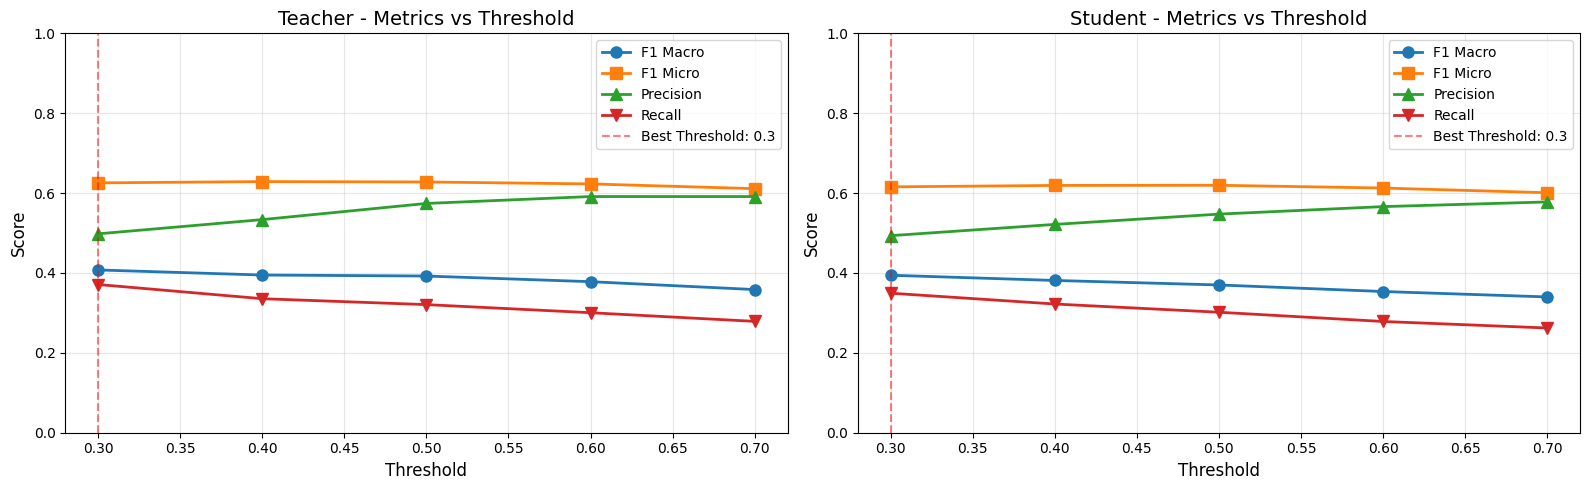

 Saved: f1_vs_threshold.png


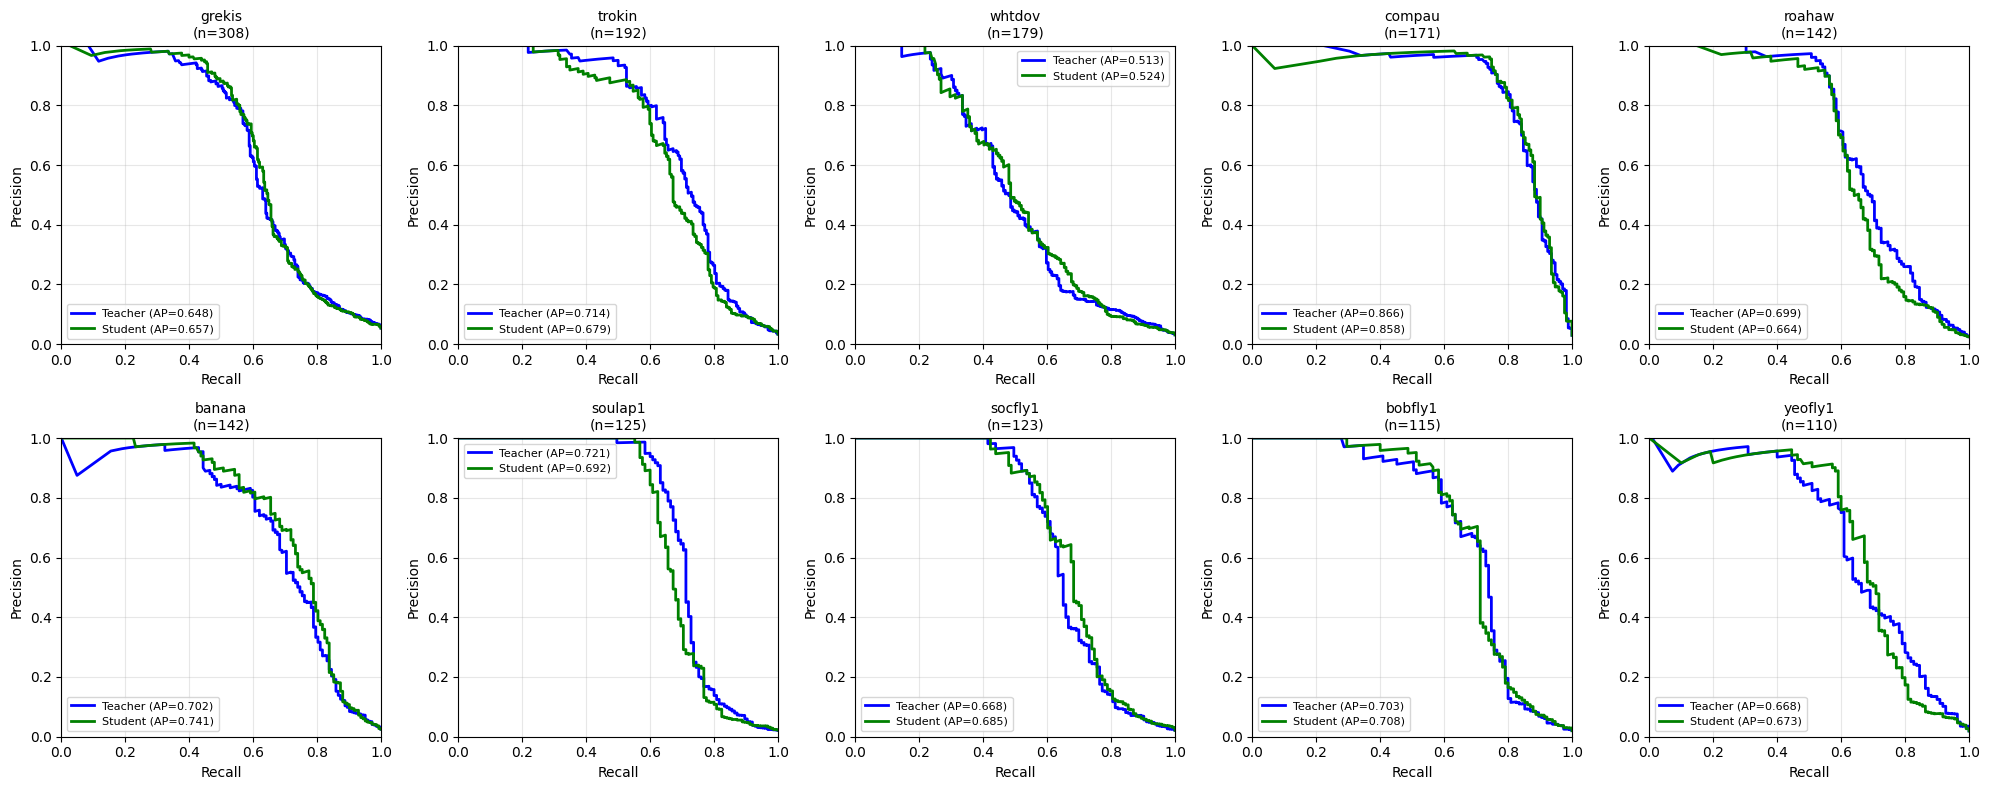

 Saved: precision_recall_curves.png


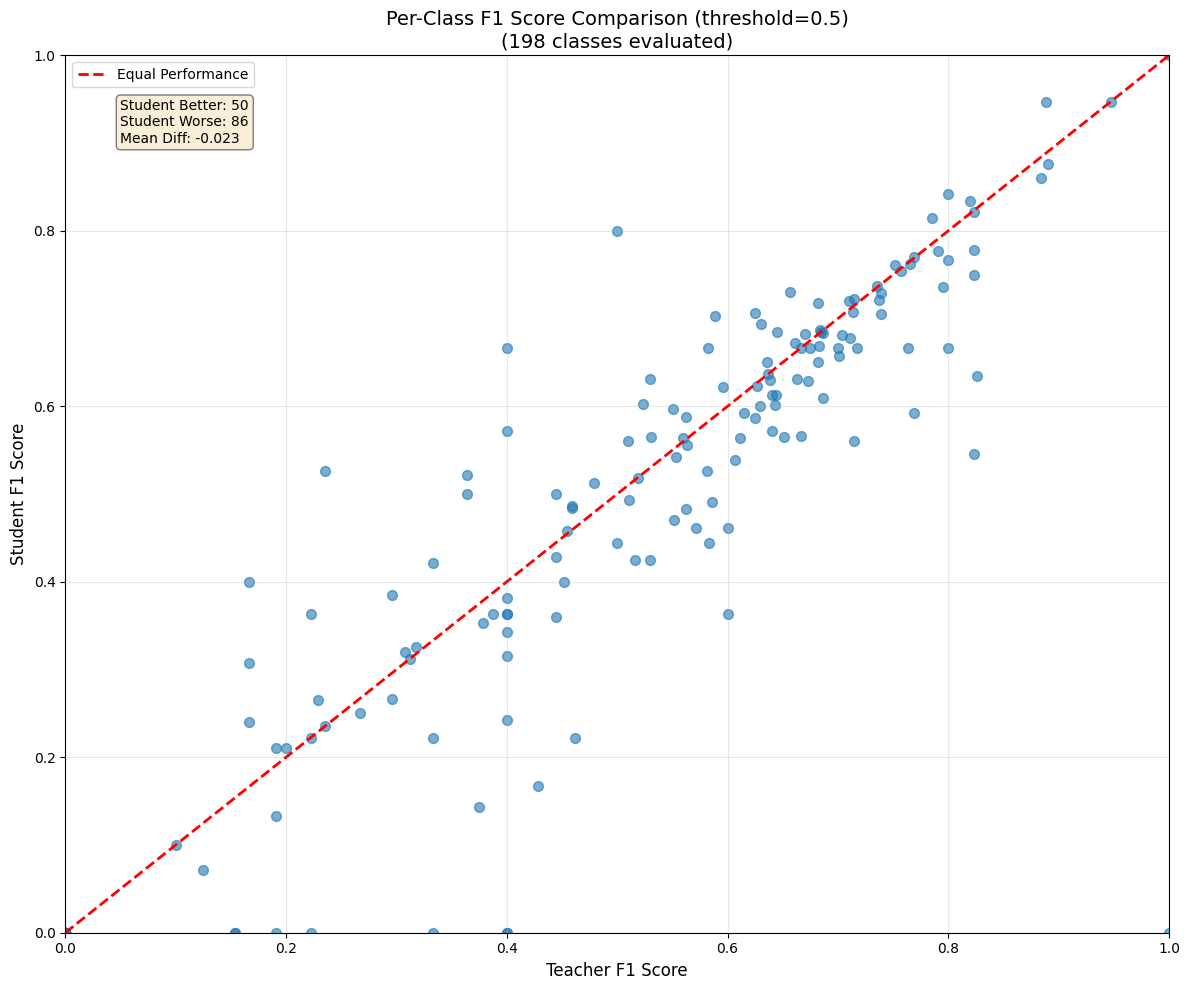

Saved: per_class_f1_scatter.png


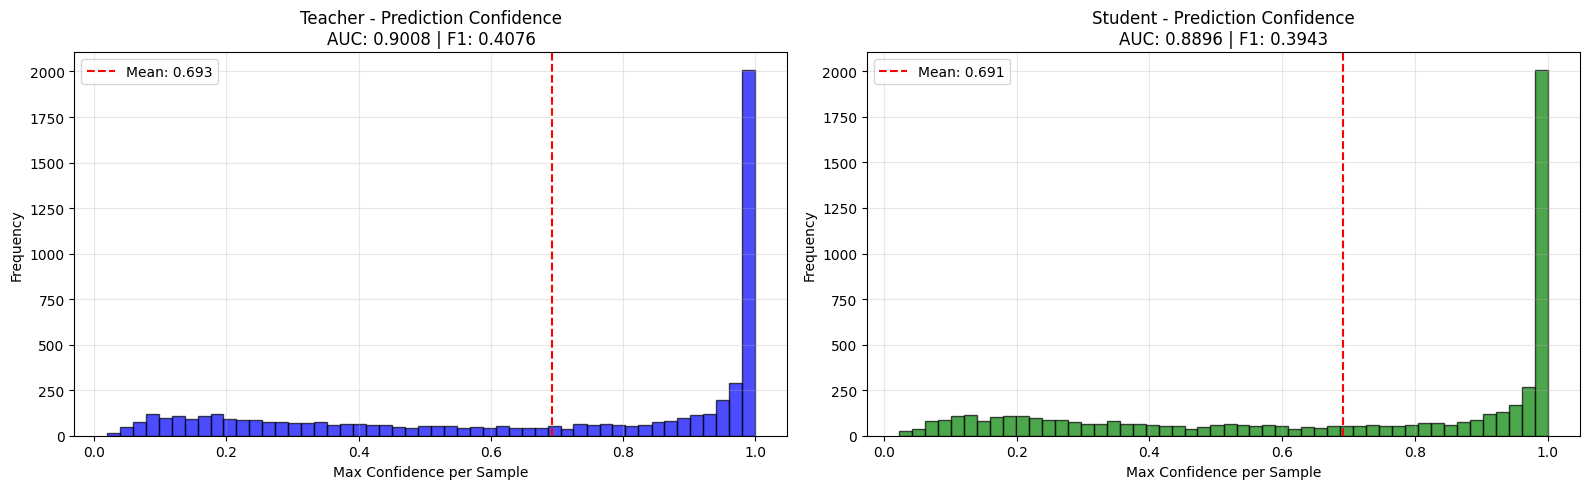

 Saved: confidence_distribution.png


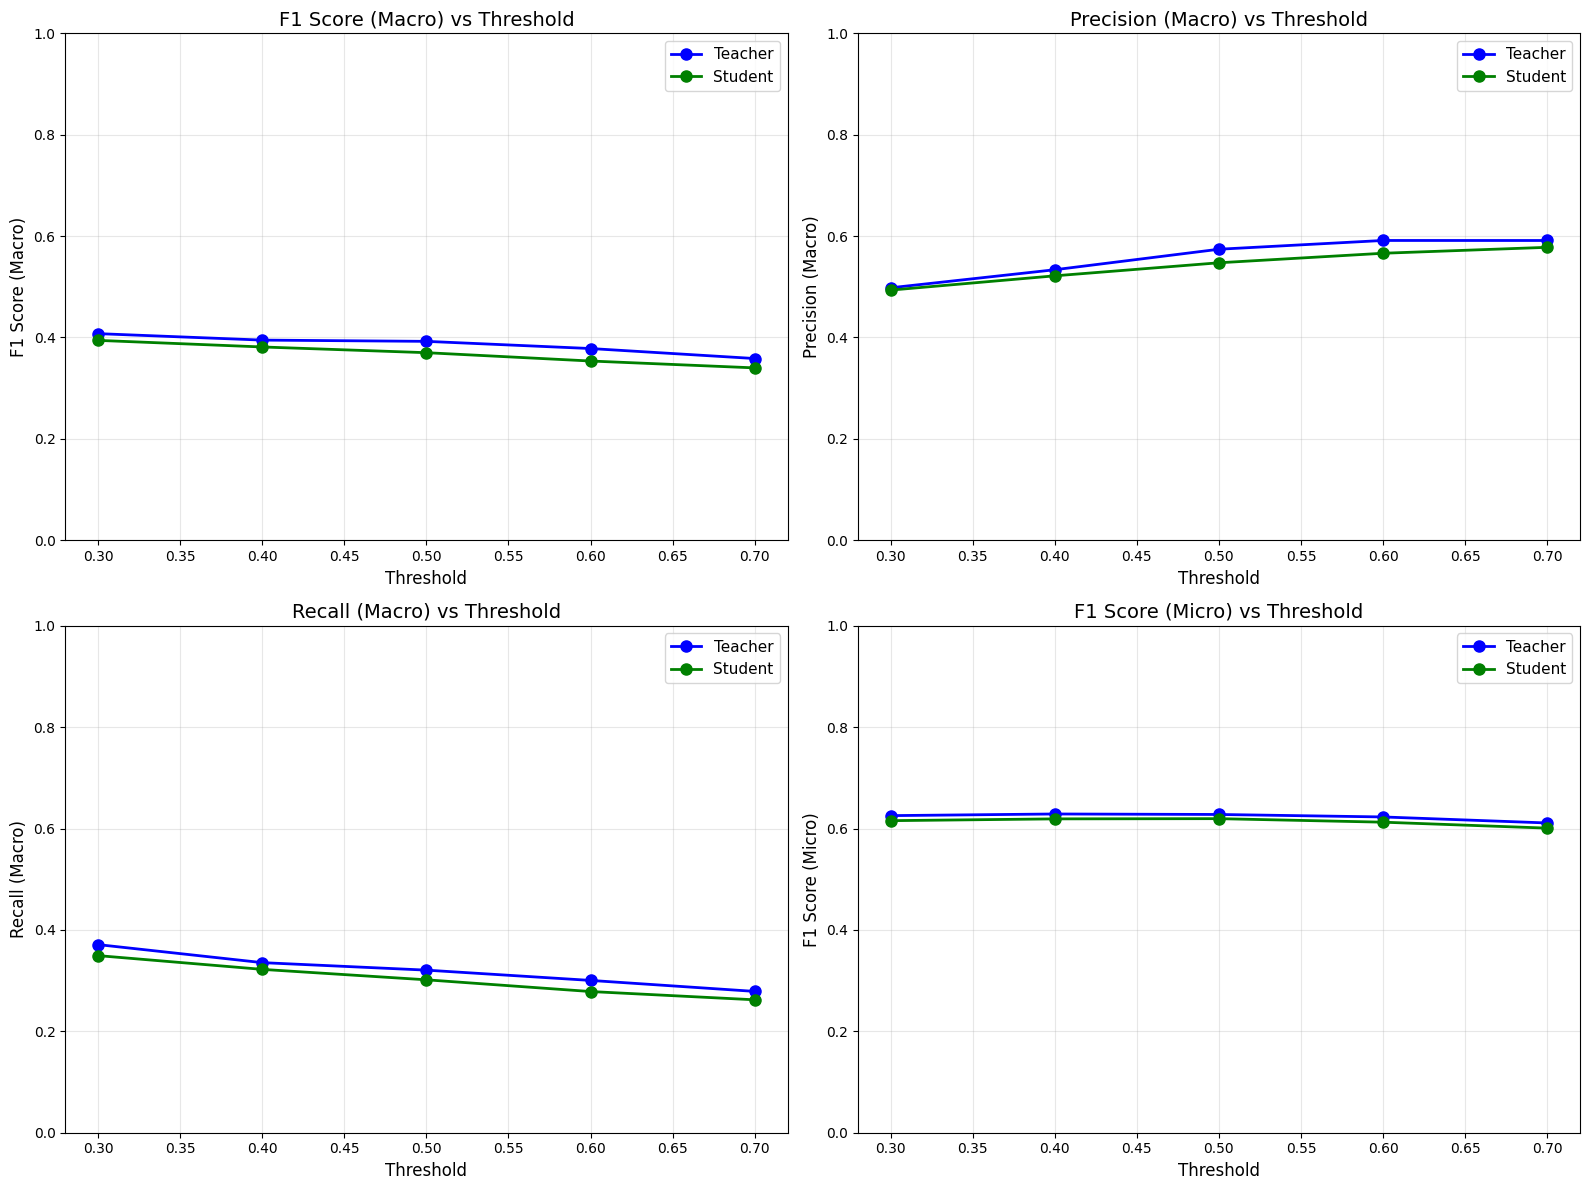

 Saved: metrics_comparison_thresholds.png

 PER-CLASS F1 SCORE ANALYSIS (threshold=0.5)

Classes evaluated: 198
Mean Teacher F1: 0.4082
Mean Student F1: 0.3849
Mean Difference: -0.0233

 Top 10 Classes - Student F1 Score:
--------------------------------------------------------------------------------
   715170               | Student: 1.0000 | Teacher: 1.0000 | Diff: +0.0000 | n=3
   22333                | Student: 0.9474 | Teacher: 0.9474 | Diff: +0.0000 | n=10
   22976                | Student: 0.9474 | Teacher: 0.8889 | Diff: +0.0585 | n=9
   bkmtou1              | Student: 0.8760 | Teacher: 0.8908 | Diff: -0.0147 | n=63
   laufal1              | Student: 0.8602 | Teacher: 0.8840 | Diff: -0.0238 | n=96
   rufmot1              | Student: 0.8421 | Teacher: 0.8000 | Diff: +0.0421 | n=21
   gycwor1              | Student: 0.8345 | Teacher: 0.8201 | Diff: +0.0144 | n=77
   compau               | Student: 0.8218 | Teacher: 0.8232 | Diff: -0.0014 | n=171
   21211                | Student:

In [17]:
def compare_models(teacher_path, student_path, val_df, cfg, spectrograms=None):
    """
    Compares Teacher vs. Student models using detailed visualizations, F1 Score, and a complete analysis.
    """

    
    print("="*60)
    print("TEACHER vs STUDENT COMPARISON")
    print("="*60)
    
    results = {}
    all_model_predictions = {}
    
    # ========================================================
    # 1. EVALUATE MODELS
    # ========================================================
    for model_name, model_path in [("Teacher", teacher_path), ("Student", student_path)]:
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print(f"{'='*60}")
        
        if not os.path.exists(model_path):
            print(f" Model not found: {model_path}")
            continue
        
        model = BirdCLEFModel(cfg).to(cfg.device)
        checkpoint = torch.load(model_path, map_location=cfg.device)
        
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            saved_auc = checkpoint.get('val_auc', 'N/A')
            print(f" Loaded (Saved AUC: {saved_auc})")
        else:
            model.load_state_dict(checkpoint)
            print(f" Loaded")
        
        model.eval()
        
        val_dataset = BirdCLEFDatasetFromNPY(val_df, cfg, spectrograms=spectrograms, mode='valid')
        val_loader = DataLoader(
            val_dataset, 
            batch_size=cfg.batch_size, 
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=True,
            collate_fn=collate_fn
        )
        
        print(f"Running inference on {len(val_df)} samples...")
        all_preds = []
        all_targets = []
        all_losses = []
        all_filenames = []
        
        criterion = get_criterion(cfg)
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Evaluating {model_name}"):
                inputs = batch['melspec'].to(cfg.device)
                targets = batch['target'].to(cfg.device)
                filenames = batch['filename']
                
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                targets_np = targets.cpu().numpy()
                
                all_preds.append(probs)
                all_targets.append(targets_np)
                all_losses.append(loss.item())
                all_filenames.extend(filenames)
        
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        avg_loss = np.mean(all_losses)
        
        # ========================================================
        # COMPUTE METRICS ACROSS VARIOUS THRESHOLDS
        # ========================================================
        print(f"\nCalculating metrics for different thresholds...")
        
        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        threshold_metrics = {}
        
        for threshold in thresholds:
            preds_binary = (all_preds >= threshold).astype(int)
            
            f1_macro = f1_score(all_targets, preds_binary, average='macro', zero_division=0)
            precision_macro = precision_score(all_targets, preds_binary, average='macro', zero_division=0)
            recall_macro = recall_score(all_targets, preds_binary, average='macro', zero_division=0)
            
            f1_micro = f1_score(all_targets, preds_binary, average='micro', zero_division=0)
            precision_micro = precision_score(all_targets, preds_binary, average='micro', zero_division=0)
            recall_micro = recall_score(all_targets, preds_binary, average='micro', zero_division=0)
            
            f1_samples = f1_score(all_targets, preds_binary, average='samples', zero_division=0)
            
            threshold_metrics[threshold] = {
                'f1_macro': f1_macro,
                'precision_macro': precision_macro,
                'recall_macro': recall_macro,
                'f1_micro': f1_micro,
                'precision_micro': precision_micro,
                'recall_micro': recall_micro,
                'f1_samples': f1_samples
            }
        
        best_threshold = max(threshold_metrics.keys(), 
                            key=lambda t: threshold_metrics[t]['f1_macro'])
        
        val_auc = calculate_auc(all_targets, all_preds)
        
        try:
            avg_precision = average_precision_score(all_targets, all_preds, average='macro')
        except:
            avg_precision = None
        
        results[model_name] = {
            'loss': avg_loss,
            'auc': val_auc,
            'avg_precision': avg_precision,
            'threshold_metrics': threshold_metrics,
            'best_threshold': best_threshold,
            'predictions': all_preds,
            'targets': all_targets,
            'filenames': all_filenames
        }
        
        print(f"\n{model_name} Results:")
        print(f"   Loss:           {avg_loss:.4f}")
        print(f"   AUC (ROC):      {val_auc:.4f}")
        if avg_precision:
            print(f"   Avg Precision:  {avg_precision:.4f}")
        print(f"\n   Best Threshold: {best_threshold}")
        print(f"   F1 (macro):     {threshold_metrics[best_threshold]['f1_macro']:.4f}")
        print(f"   Precision:      {threshold_metrics[best_threshold]['precision_macro']:.4f}")
        print(f"   Recall:         {threshold_metrics[best_threshold]['recall_macro']:.4f}")
        
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    if len(results) == 2:
        print("\n" + "="*60)
        print("DETAILED COMPARISON SUMMARY")
        print("="*60)
        
        teacher_auc = results['Teacher']['auc']
        student_auc = results['Student']['auc']
        teacher_loss = results['Teacher']['loss']
        student_loss = results['Student']['loss']
        
        teacher_best_th = results['Teacher']['best_threshold']
        student_best_th = results['Student']['best_threshold']
        
        teacher_f1 = results['Teacher']['threshold_metrics'][teacher_best_th]['f1_macro']
        student_f1 = results['Student']['threshold_metrics'][student_best_th]['f1_macro']
        
        teacher_precision = results['Teacher']['threshold_metrics'][teacher_best_th]['precision_macro']
        student_precision = results['Student']['threshold_metrics'][student_best_th]['precision_macro']
        
        teacher_recall = results['Teacher']['threshold_metrics'][teacher_best_th]['recall_macro']
        student_recall = results['Student']['threshold_metrics'][student_best_th]['recall_macro']
        
        print(f"\n Main Metrics Comparison:")
        print(f"{'Metric':<20} {'Teacher':<12} {'Student':<12} {'Difference':<15}")
        print("-" * 60)
        print(f"{'AUC (ROC)':<20} {teacher_auc:<12.4f} {student_auc:<12.4f} {student_auc-teacher_auc:+.4f} ({((student_auc-teacher_auc)/teacher_auc)*100:+.2f}%)")
        print(f"{'Loss':<20} {teacher_loss:<12.4f} {student_loss:<12.4f} {student_loss-teacher_loss:+.4f}")
        print(f"{'F1 Score (macro)':<20} {teacher_f1:<12.4f} {student_f1:<12.4f} {student_f1-teacher_f1:+.4f} ({((student_f1-teacher_f1)/teacher_f1)*100:+.2f}%)")
        print(f"{'Precision (macro)':<20} {teacher_precision:<12.4f} {student_precision:<12.4f} {student_precision-teacher_precision:+.4f}")
        print(f"{'Recall (macro)':<20} {teacher_recall:<12.4f} {student_recall:<12.4f} {student_recall-teacher_recall:+.4f}")
        print(f"{'Best Threshold':<20} {teacher_best_th:<12} {student_best_th:<12}")
        
        if results['Teacher']['avg_precision'] and results['Student']['avg_precision']:
            teacher_ap = results['Teacher']['avg_precision']
            student_ap = results['Student']['avg_precision']
            print(f"{'Avg Precision':<20} {teacher_ap:<12.4f} {student_ap:<12.4f} {student_ap-teacher_ap:+.4f}")
        
        improvement = student_auc - teacher_auc
        
        print(f"\n{'='*60}")
        if improvement > 0:
            print(" Student IMPROVED over Teacher!")
        elif improvement > -0.05:
            print(" Student slightly worse than Teacher (acceptable)")
        else:
            print(" Student significantly worse than Teacher")
        print(f"{'='*60}")
        
        print("\n  Generating visualizations...")
        
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        species_list = taxonomy_df['primary_label'].tolist()
        
        teacher_preds = results['Teacher']['predictions']
        student_preds = results['Student']['predictions']
        targets = results['Teacher']['targets']
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        thresholds_list = sorted(results['Teacher']['threshold_metrics'].keys())
        
        for idx, model_name in enumerate(['Teacher', 'Student']):
            metrics = results[model_name]['threshold_metrics']
            
            f1_macros = [metrics[t]['f1_macro'] for t in thresholds_list]
            f1_micros = [metrics[t]['f1_micro'] for t in thresholds_list]
            precisions = [metrics[t]['precision_macro'] for t in thresholds_list]
            recalls = [metrics[t]['recall_macro'] for t in thresholds_list]
            
            axes[idx].plot(thresholds_list, f1_macros, 'o-', label='F1 Macro', linewidth=2, markersize=8)
            axes[idx].plot(thresholds_list, f1_micros, 's-', label='F1 Micro', linewidth=2, markersize=8)
            axes[idx].plot(thresholds_list, precisions, '^-', label='Precision', linewidth=2, markersize=8)
            axes[idx].plot(thresholds_list, recalls, 'v-', label='Recall', linewidth=2, markersize=8)
            
            best_th = results[model_name]['best_threshold']
            axes[idx].axvline(best_th, color='red', linestyle='--', alpha=0.5, 
                             label=f'Best Threshold: {best_th}')
            
            axes[idx].set_xlabel('Threshold', fontsize=12)
            axes[idx].set_ylabel('Score', fontsize=12)
            axes[idx].set_title(f'{model_name} - Metrics vs Threshold', fontsize=14)
            axes[idx].legend(fontsize=10)
            axes[idx].grid(alpha=0.3)
            axes[idx].set_ylim([0, 1])
        
        plt.tight_layout()
        plt.savefig('f1_vs_threshold.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(" Saved: f1_vs_threshold.png")
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        class_counts = targets.sum(axis=0)
        top_classes = np.argsort(class_counts)[-10:][::-1]
        
        for idx, class_id in enumerate(top_classes):
            y_true = targets[:, class_id]
            
            if y_true.sum() > 0 and y_true.sum() < len(y_true):
                # Teacher PR curve
                teacher_y_pred = teacher_preds[:, class_id]
                precision_t, recall_t, _ = precision_recall_curve(y_true, teacher_y_pred)
                ap_t = average_precision_score(y_true, teacher_y_pred)
                
                # Student PR curve
                student_y_pred = student_preds[:, class_id]
                precision_s, recall_s, _ = precision_recall_curve(y_true, student_y_pred)
                ap_s = average_precision_score(y_true, student_y_pred)
                
                # Plot
                axes[idx].plot(recall_t, precision_t, 'b-', label=f'Teacher (AP={ap_t:.3f})', linewidth=2)
                axes[idx].plot(recall_s, precision_s, 'g-', label=f'Student (AP={ap_s:.3f})', linewidth=2)
                axes[idx].set_xlabel('Recall')
                axes[idx].set_ylabel('Precision')
                
                species_name = species_list[class_id] if class_id < len(species_list) else f'Class {class_id}'
                axes[idx].set_title(f'{species_name}\n(n={int(y_true.sum())})', fontsize=10)
                axes[idx].legend(fontsize=8)
                axes[idx].grid(alpha=0.3)
                axes[idx].set_xlim([0, 1])
                axes[idx].set_ylim([0, 1])
        
        plt.tight_layout()
        plt.savefig('precision_recall_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(" Saved: precision_recall_curves.png")
        
        fig, ax = plt.subplots(figsize=(12, 10))

        teacher_preds_binary = (teacher_preds >= 0.5).astype(int)
        student_preds_binary = (student_preds >= 0.5).astype(int)
        
        class_f1_teacher = []
        class_f1_student = []
        valid_classes = []
        
        for i in range(cfg.num_classes):
            y_true = targets[:, i]
            
            if y_true.sum() > 0:
                try:
                    f1_t = f1_score(y_true, teacher_preds_binary[:, i], zero_division=0)
                    f1_s = f1_score(y_true, student_preds_binary[:, i], zero_division=0)
                    
                    class_f1_teacher.append(f1_t)
                    class_f1_student.append(f1_s)
                    valid_classes.append(i)
                except:
                    pass
        
        class_f1_teacher = np.array(class_f1_teacher)
        class_f1_student = np.array(class_f1_student)
        
        ax.scatter(class_f1_teacher, class_f1_student, alpha=0.6, s=50)
        ax.plot([0, 1], [0, 1], 'r--', label='Equal Performance', linewidth=2)
        ax.set_xlabel('Teacher F1 Score', fontsize=12)
        ax.set_ylabel('Student F1 Score', fontsize=12)
        ax.set_title(f'Per-Class F1 Score Comparison (threshold=0.5)\n({len(valid_classes)} classes evaluated)', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        

        diff = class_f1_student - class_f1_teacher
        better = (diff > 0).sum()
        worse = (diff < 0).sum()
        
        textstr = f'Student Better: {better}\nStudent Worse: {worse}\nMean Diff: {diff.mean():+.3f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.savefig('per_class_f1_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: per_class_f1_scatter.png")
        

        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # Teacher
        teacher_max_conf = teacher_preds.max(axis=1)
        axes[0].hist(teacher_max_conf, bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0].axvline(teacher_max_conf.mean(), color='red', linestyle='--', 
                       label=f'Mean: {teacher_max_conf.mean():.3f}')
        axes[0].set_xlabel('Max Confidence per Sample')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'Teacher - Prediction Confidence\nAUC: {teacher_auc:.4f} | F1: {teacher_f1:.4f}')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Student
        student_max_conf = student_preds.max(axis=1)
        axes[1].hist(student_max_conf, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[1].axvline(student_max_conf.mean(), color='red', linestyle='--',
                       label=f'Mean: {student_max_conf.mean():.3f}')
        axes[1].set_xlabel('Max Confidence per Sample')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title(f'Student - Prediction Confidence\nAUC: {student_auc:.4f} | F1: {student_f1:.4f}')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(" Saved: confidence_distribution.png")
        

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        metrics_to_plot = [
            ('f1_macro', 'F1 Score (Macro)'),
            ('precision_macro', 'Precision (Macro)'),
            ('recall_macro', 'Recall (Macro)'),
            ('f1_micro', 'F1 Score (Micro)')
        ]
        
        for idx, (metric_key, metric_name) in enumerate(metrics_to_plot):
            ax = axes[idx // 2, idx % 2]
            
            teacher_values = [results['Teacher']['threshold_metrics'][t][metric_key] for t in thresholds_list]
            student_values = [results['Student']['threshold_metrics'][t][metric_key] for t in thresholds_list]
            
            ax.plot(thresholds_list, teacher_values, 'bo-', label='Teacher', linewidth=2, markersize=8)
            ax.plot(thresholds_list, student_values, 'go-', label='Student', linewidth=2, markersize=8)
            
            ax.set_xlabel('Threshold', fontsize=12)
            ax.set_ylabel(metric_name, fontsize=12)
            ax.set_title(f'{metric_name} vs Threshold', fontsize=14)
            ax.legend(fontsize=11)
            ax.grid(alpha=0.3)
            ax.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.savefig('metrics_comparison_thresholds.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(" Saved: metrics_comparison_thresholds.png")
        

        print("\n" + "="*60)
        print(" PER-CLASS F1 SCORE ANALYSIS (threshold=0.5)")
        print("="*60)
        

        class_analysis = []
        for i in valid_classes:
            species_name = species_list[i] if i < len(species_list) else f'Class_{i}'
            n_samples = int(targets[:, i].sum())
            
            f1_t = class_f1_teacher[valid_classes.index(i)]
            f1_s = class_f1_student[valid_classes.index(i)]
            
            class_analysis.append({
                'class_id': i,
                'species': species_name,
                'n_samples': n_samples,
                'teacher_f1': f1_t,
                'student_f1': f1_s,
                'difference': f1_s - f1_t
            })
        
        class_df = pd.DataFrame(class_analysis)
        
        print(f"\nClasses evaluated: {len(class_df)}")
        print(f"Mean Teacher F1: {class_df['teacher_f1'].mean():.4f}")
        print(f"Mean Student F1: {class_df['student_f1'].mean():.4f}")
        print(f"Mean Difference: {class_df['difference'].mean():+.4f}")
        
        print("\n Top 10 Classes - Student F1 Score:")
        print("-" * 80)
        top_10_student = class_df.nlargest(10, 'student_f1')
        for idx, row in top_10_student.iterrows():
            print(f"   {row['species']:20} | Student: {row['student_f1']:.4f} | Teacher: {row['teacher_f1']:.4f} | Diff: {row['difference']:+.4f} | n={row['n_samples']}")
        
        print("\n Top 10 Largest Improvements (Student - Teacher):")
        print("-" * 80)
        top_improvements = class_df.nlargest(10, 'difference')
        for idx, row in top_improvements.iterrows():
            print(f"   {row['species']:20} | Improvement: {row['difference']:+.4f} | Student: {row['student_f1']:.4f} | Teacher: {row['teacher_f1']:.4f} | n={row['n_samples']}")
        
        print("\n Top 10 Largest Degradations (Student - Teacher):")
        print("-" * 80)
        worst_degradations = class_df.nsmallest(10, 'difference')
        for idx, row in worst_degradations.iterrows():
            print(f"   {row['species']:20} | Degradation: {row['difference']:+.4f} | Student: {row['student_f1']:.4f} | Teacher: {row['teacher_f1']:.4f} | n={row['n_samples']}")
        
        print("="*60)
    
    return results

if __name__ == "__main__":
    print("Loading data...")
    train_df = pd.read_csv(cfg.train_csv)
    
    spectrograms = None
    if cfg.LOAD_DATA:
        try:
            print("Loading spectrograms...")
            spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
            print(f" Loaded {len(spectrograms)} spectrograms")
        except Exception as e:
            print(f"  Could not load spectrograms: {e}")
    
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    splits = list(skf.split(train_df, train_df['primary_label']))
    train_idx, val_idx = splits[0]
    val_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    print(f"Validation samples: {len(val_df)}")
    
    teacher_path = "/kaggle/input/birdclef25-effnetb0-starter-weight/best.pth"
    student_path = "/kaggle/working/model_student0.pth"
    
    results = compare_models(teacher_path, student_path, val_df, cfg, spectrograms)

In [18]:
def compare_models(teacher_path, student_path, val_df, cfg, spectrograms=None):
    """
    Compares the performance of the Teacher vs. the Student.
    """
    print("="*60)
    print("TEACHER vs STUDENT COMPARISON")
    print("="*60)
    
    results = {}
    
    for model_name, model_path in [("Teacher", teacher_path), ("Student", student_path)]:
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print(f"{'='*60}")
        
        if not os.path.exists(model_path):
            print(f"Model not found: {model_path}")
            continue
        
        model = BirdCLEFModel(cfg).to(cfg.device)
        checkpoint = torch.load(model_path, map_location=cfg.device)
        
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model.eval()
        
        val_dataset = BirdCLEFDatasetFromNPY(val_df, cfg, spectrograms=spectrograms, mode='valid')
        val_loader = DataLoader(
            val_dataset, 
            batch_size=cfg.batch_size, 
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=True,
            collate_fn=collate_fn
        )
        
        criterion = get_criterion(cfg)
        val_loss, val_auc = validate(model, val_loader, criterion, cfg.device)
        
        results[model_name] = {
            'loss': val_loss,
            'auc': val_auc
        }
        
        print(f"\n{model_name} Results:")
        print(f"   Loss: {val_loss:.4f}")
        print(f"   AUC:  {val_auc:.4f}")
        
        del model
        torch.cuda.empty_cache()
    

    if len(results) == 2:
        print("\n" + "="*60)
        print("COMPARISON SUMMARY")
        print("="*60)
        
        teacher_auc = results['Teacher']['auc']
        student_auc = results['Student']['auc']
        improvement = student_auc - teacher_auc
        improvement_pct = (improvement / teacher_auc) * 100
        
        print(f"\nTeacher AUC: {teacher_auc:.4f}")
        print(f"Student AUC: {student_auc:.4f}")
        print(f"Difference:  {improvement:+.4f} ({improvement_pct:+.2f}%)")
        
        if improvement > 0:
            print("\n Student improved over Teacher!")
        elif improvement > -0.05:
            print("\n  Student slightly worse than Teacher (acceptable)")
        else:
            print("\n Student significantly worse than Teacher")
        
        print("="*60)
    
    return results


if __name__ == "__main__":
    train_df = pd.read_csv(cfg.train_csv)
    
    spectrograms = None
    if cfg.LOAD_DATA:
        try:
            spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
        except:
            pass
    
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    splits = list(skf.split(train_df, train_df['primary_label']))
    train_idx, val_idx = splits[0]
    val_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    teacher_path = "/kaggle/input/birdclef25-effnetb0-starter-weight/best.pth"
    student_path = "/kaggle/working/model_student0.pth"
    
    compare_models(teacher_path, student_path, val_df, cfg, spectrograms)

TEACHER vs STUDENT COMPARISON

Evaluating Teacher
Found 5713 matching spectrograms for valid dataset out of 5713 samples


Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Teacher Results:
   Loss: 0.0155
   AUC:  0.9442

Evaluating Student
Found 5713 matching spectrograms for valid dataset out of 5713 samples


Validation:   0%|          | 0/179 [00:00<?, ?it/s]


Student Results:
   Loss: 0.0160
   AUC:  0.9426

COMPARISON SUMMARY

Teacher AUC: 0.9442
Student AUC: 0.9426
Difference:  -0.0016 (-0.17%)

  Student slightly worse than Teacher (acceptable)
